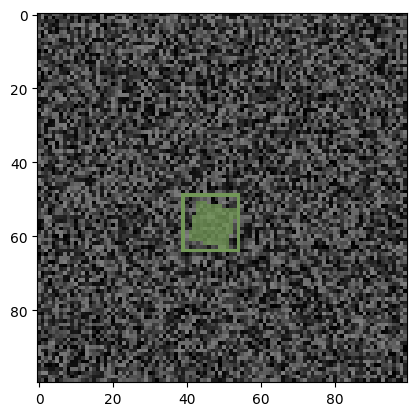

In [1]:
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
from square_data_generator import make_image
from torchvision.utils import draw_bounding_boxes

N_SQUARES = 1
IMAGE_SIZE = (100, 100)

test_img, test_bboxes, test_colors = make_image(IMAGE_SIZE, N_SQUARES)
predicted_bboxes = torchvision.ops.box_convert(
    test_bboxes, in_fmt="cxcywh", out_fmt="xyxy"
)

tuple_colors = [tuple(x.tolist()) for x in test_colors]

img_with_boxes = draw_bounding_boxes(
    (test_img.permute(2, 0, 1) * 255).to(torch.uint8),
    predicted_bboxes,
    colors=tuple_colors,
    width=1,
)
plt.imshow(img_with_boxes.permute(1, 2, 0));

In [2]:
from square_data_generator import label_sort_order_big_to_small


def ordered_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    _loss = 0

    for batch_idx in range(predicted_bboxes.size(0)):
        # sort_idx = label_sort_order_big_to_small(predicted_bboxes[batch_idx])
        for idx in range(N_SQUARES):
            _loss += nn.functional.mse_loss(
                predicted_bboxes[0, idx], target_bboxes[batch_idx][idx]
            )
    return _loss


def calculate_iou_cxcywh(
    pred_boxes: torch.Tensor, target_boxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU for bounding boxes in cxcywh format
    Boxes are expected in format [center_x, center_y, width, height]
    """
    # Convert cxcywh to corner coordinates
    pred_cx, pred_cy, pred_w, pred_h = pred_boxes.unbind(-1)
    targ_cx, targ_cy, targ_w, targ_h = target_boxes.unbind(-1)

    # Calculate corner coordinates
    pred_x1 = pred_cx - pred_w / 2
    pred_y1 = pred_cy - pred_h / 2
    pred_x2 = pred_cx + pred_w / 2
    pred_y2 = pred_cy + pred_h / 2

    targ_x1 = targ_cx - targ_w / 2
    targ_y1 = targ_cy - targ_h / 2
    targ_x2 = targ_cx + targ_w / 2
    targ_y2 = targ_cy + targ_h / 2

    # Calculate intersection coordinates
    inter_x1 = torch.max(pred_x1, targ_x1)
    inter_y1 = torch.max(pred_y1, targ_y1)
    inter_x2 = torch.min(pred_x2, targ_x2)
    inter_y2 = torch.min(pred_y2, targ_y2)

    # Calculate intersection area
    inter_width = torch.clamp(inter_x2 - inter_x1, min=0)
    inter_height = torch.clamp(inter_y2 - inter_y1, min=0)
    inter_area = inter_width * inter_height

    # Calculate union area
    pred_area = pred_w * pred_h
    targ_area = targ_w * targ_h
    union_area = pred_area + targ_area - inter_area

    # Calculate IoU
    iou = inter_area / (union_area + 1e-6)  # Add epsilon to avoid division by zero
    return iou


def ordered_iou_loss_big_to_small(
    predicted_bboxes: torch.Tensor, target_bboxes: torch.Tensor
) -> torch.Tensor:
    """
    Calculate IoU loss for ordered bounding boxes in cxcywh format
    Args:
        predicted_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
        target_bboxes: Tensor of shape (batch_size, num_boxes, 4) in [cx, cy, w, h]
    Returns:
        Total IoU loss
    """
    _loss = 0.0

    for batch_idx in range(predicted_bboxes.size(0)):
        for idx in range(5):  # Assuming 5 boxes as in original code
            # Calculate IoU for each pair of boxes
            iou = calculate_iou_cxcywh(
                predicted_bboxes[batch_idx, idx], target_bboxes[batch_idx, idx]
            )
            # Convert IoU to loss (1 - IoU)
            box_loss = 1 - iou
            _loss += box_loss

    return _loss


In [3]:
class BoundingBoxPredictor(nn.Module):
    def __init__(self, n_output_boxes: int):
        self.n_output_boxes = n_output_boxes
        super(BoundingBoxPredictor, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(
            128, n_output_boxes * 4
        )  # 5 bounding boxes * 4 coordinates each
        self.elu = nn.ELU()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.elu(x) + 1  # All values should be positive at the end.
        x = x.view(
            -1, self.n_output_boxes, 4
        )  # reshape to (batch_size, n_output_boxes, 4)
        return x

In [4]:
from torch.utils.data import Dataset, DataLoader


class SquareDataset(Dataset):
    def __init__(self, image_size, num_boxes, num_samples):
        self.image_size = image_size
        self.num_boxes = num_boxes
        self.num_samples = num_samples
        self.images = []
        self.bboxes = []

        # precomputing
        for _ in range(num_samples):
            img, bboxes, _ = make_image(self.image_size, self.num_boxes)
            self.images.append(img.permute(2, 0, 1))
            self.bboxes.append(bboxes)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.bboxes[idx]


# Parameters
image_size = (100, 100)
num_boxes = 5
num_samples = 1000
batch_size = 32

# Create dataset and dataloader
dataset = SquareDataset(image_size, num_boxes, num_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example usage
for batch_imgs, batch_bboxes in dataloader:
    print(batch_imgs.shape)  # Should be [batch_size, 3, 100, 100]
    print(batch_bboxes.shape)  # Should be [batch_size, num_boxes, 4]
    break

torch.Size([32, 3, 100, 100])
torch.Size([32, 5, 4])


In [5]:
dataset = SquareDataset(
    image_size=(100, 100),
    num_boxes=N_SQUARES,
    num_samples=1000,
)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# Training parameters
num_epochs = 2
learning_rate = 0.001

# Initialize model, loss function, and optimizer
model = BoundingBoxPredictor(n_output_boxes=N_SQUARES)
criterion = ordered_iou_loss_big_to_small
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

test_images = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, target_bboxes in dataloader:
        optimizer.zero_grad()
        predicted_bboxes = model(images)
        loss = criterion(predicted_bboxes, target_bboxes)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

    model.eval()
    with torch.no_grad():
        test_pred_bboxes = model(test_img.unsqueeze(0))
        test_pred_bboxes = torchvision.ops.box_convert(
            test_pred_bboxes.squeeze(0), in_fmt="cxcywh", out_fmt="xyxy"
        )
        test_images.append(
            draw_bounding_boxes(
                (test_img.permute(2, 0, 1) * 255).to(torch.uint8),
                test_pred_bboxes,
                colors=tuple_colors,
                width=1,
            )
        )


IndexError: index 1 is out of bounds for dimension 1 with size 1

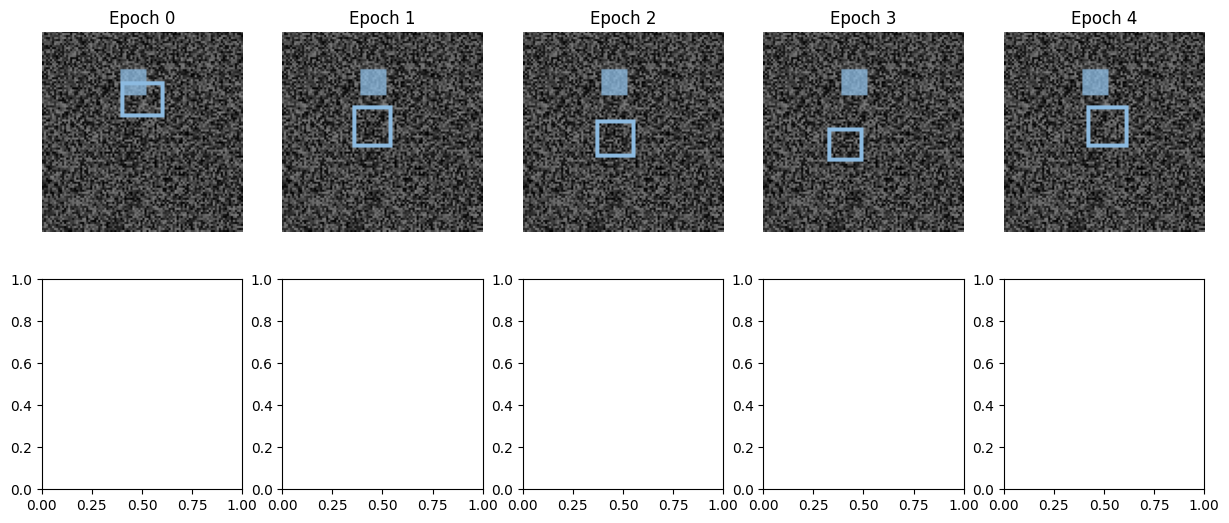

In [ ]:
# go through all images and plot them in a img grid
n_images = len(test_images)
n_cols = 5
n_rows = n_images // n_cols + 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
for i in range(n_images):
    this_ax = ax[i // n_cols, i % n_cols]
    this_ax.imshow(test_images[i].permute(1, 2, 0), origin="lower")
    this_ax.axis("off")
    this_ax.set_title(f"Epoch {i * EPOCH_PRINT_INTERVAL}")
plt.show()